# Import modules

In [1]:
import numpy as np
import pandas as pd
import geojson
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import seaborn as sns
from skimage import draw
import geopandas as gpd
from shapely import geometry, ops
import rasterio
from rasterio import features

%matplotlib inline

In [2]:
sns.set()
sns.set_palette("husl", 8)

# Create a flow direction grid from a raster

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [3]:
grid = Grid.from_raster("../data/n30w100_dir", data_name="dir")

# Specify flow direction values

In [4]:
# N    NE    E    SE    S    SW    W    NW
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Delineate catchment

In [5]:
# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(
    data="dir",
    x=x,
    y=y,
    dirmap=dirmap,
    out_name="catch",
    recursionlimit=15000,
    xytype="label",
)

In [6]:
# Clip the bounding box to the catchment
grid.clip_to("catch")

# Get catchment outline as vector polygon

In [7]:
# The polygonize argument defaults to the grid mask when no arguments are supplied
shapes = grid.polygonize()

Text(0.5,1,'Catchment boundary (vector)')

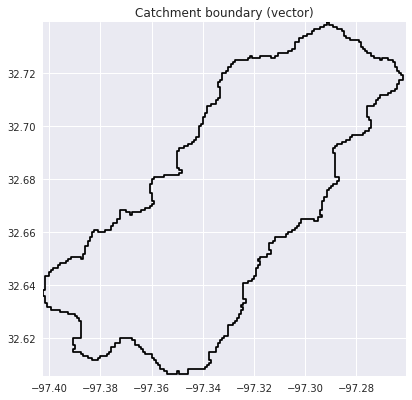

In [8]:
# Plot catchment boundaries
fig, ax = plt.subplots(figsize=(6.5, 6.5))

for shape in shapes:
    coords = np.asarray(shape[0]["coordinates"][0])
    ax.plot(coords[:, 0], coords[:, 1], color="k")

ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title("Catchment boundary (vector)")

# Read soil type shapefile

In [9]:
soils = gpd.read_file("../data/nrcs-soils_48439_tarrant/")

# Clip soil shapefile to catchment boundary

In [10]:
shapes = grid.polygonize()
catchment_polygon = ops.unary_union([geometry.shape(shape) for shape, value in shapes])

In [11]:
soil_id = "MUKEY"
soils = soils[soils.intersects(catchment_polygon)]
catchment_soils = gpd.GeoDataFrame(soils[soil_id], geometry=soils.intersection(catchment_polygon))
# Convert soil types to simple integer values
soil_types = np.unique(catchment_soils[soil_id])
soil_types = pd.Series(np.arange(soil_types.size), index=soil_types)
catchment_soils[soil_id] = catchment_soils[soil_id].map(soil_types)

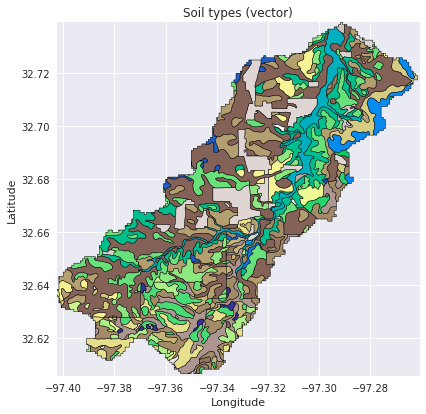

In [12]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))
catchment_soils.plot(
    ax=ax,
    column=soil_id,
    categorical=True,
    cmap="terrain",
    linewidth=0.5,
    edgecolor="k",
    alpha=1,
)
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.set_title("Soil types (vector)")
plt.savefig("img/vector_soil.png")

# Rasterize soil data in catchment

In [13]:
soil_polygons = zip(catchment_soils.geometry.values, catchment_soils[soil_id].values)
soil_raster = grid.rasterize(soil_polygons, fill=np.nan)

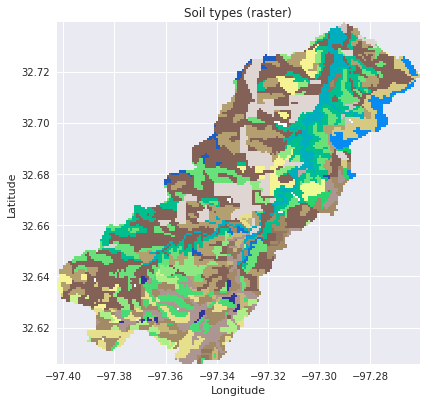

In [14]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))
plt.imshow(soil_raster, cmap="terrain", extent=grid.extent, zorder=1)
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.set_title("Soil types (raster)")
plt.savefig("img/raster_soil.png")